In [1]:
import numpy as np
import cobra 
import snek
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

# Relationship growth to uptake

In [2]:
ecoli = cobra.io.read_sbml_model("working_examples/230502_mcPECASO/iJO1366.xml")

In [3]:
min_qX = np.linspace(0,1,101)
min_qG = []
with ecoli as tmp:
    for qX in min_qX:
        # even though Fig. 3a suggests it, the ATPM lb seems not to be turned off in the original
        # mcPECASO implementation
        # snek.set_bounds(tmp,"ATPM",lb=0)
        snek.set_bounds(tmp,"BIOMASS_Ec_iJO1366_core_53p95M",qX,qX)
        snek.set_bounds(tmp,"EX_glc__D_e",lb=-1000)
        snek.set_objective(tmp,"EX_glc__D_e","max")
        sol = snek.sensitive_optimize(tmp)
        tmp_qG = -sol["EX_glc__D_e"]
        min_qG.append(tmp_qG)
print("done")

done


In [4]:
def get_qG(qX):
    #...Model fixed Parameters
    qmin = 0.5
    qmax = 10.0
    Kup = 5
    
    qG = qmin + (qmax - qmin)*(-1 + 2/(1 + np.exp(-Kup*qX)))
    return qG

# Sanity Check Function

In [5]:
def sanity_check(dirname):
    
    dflb = pd.read_csv("simulations/"+dirname+"/vlb.csv",header=None)
    dfub = pd.read_csv("simulations/"+dirname+"/vub.csv",header=None)
    dfq = pd.read_csv("simulations/"+dirname+"/q.csv", header=None)

    for i in range(dfq.shape[1]):

        tmp_q = dfq.iloc[:,i]
        n = 0
        for j in range(len(tmp_q)):
            _q  = round(tmp_q[j],6)
            _lb = dflb.loc[j,0]
            _ub = dfub.loc[j,0]

            if _q <= _ub and _q >= _lb:
                pass
            else:
                n += 1
        if n > 0:
            print("Control Interval Nr",i)
            print("Nr of failed fluxes",n,"\n")
    print('Finished flux bound check.')

    with ecoli as tmp:
        for i in range(dfq.shape[1]):
            tmp_q = dfq.iloc[:,i]
            tmp_q = round(tmp_q,6)
            # assert that the # of reactions is equal
            assert len(tmp.reactions) == len(tmp_q)

            rel_err = .001
            abs_err = .001
            for r,v in zip(tmp.reactions,tmp_q):
                if v < 0:
                    vlb = v*(1+rel_err)-abs_err
                    vub = v*(1-rel_err)+abs_err
                else:
                    vlb = v*(1-rel_err)-abs_err
                    vub = v*(1+rel_err)+abs_err
                snek.set_bounds(tmp,r.id,lb=vlb,ub=vub)
            sol = tmp.optimize() #snek.sensitive_optimize(tmp)
            if sol.status != "optimal":
                print("Control Interval Nr",i)
                print(sol.status)
    print('Finished FBA feasibility check.')

# Analyse Scripts

In [51]:
dirname = "mcp_v227"
sanity_check(dirname)

Finished flux bound check.
Finished FBA feasibility check.


## Print Process Summary

In [52]:
def parse_summary_file(dirname):
    # get summary
    with open("simulations/"+dirname+"/summary.txt","r") as file:
        lines = file.readlines()

    timing = False
    sum_dic = {}
    for i, line in enumerate(lines):
        if (i-2)%3 == 0:
            pass
        elif (i-1)%3 == 0:
            if line[0].isnumeric() or line[0] == "-":
                tmp_item = [float(line)]
            else:
                tmp_str = line.strip("\n")
                if tmp_str[0] == "[":
                    tmp_item = [[float(i) for i in tmp_str.strip("[").strip("]").split(",")]]
                else:
                    tmp_item = [tmp_str]
                pass
            if timing:
                sum_dic[tmp_key+" in s"] = tmp_item
                sum_dic[tmp_key+" in min"] = [i/60 for i in tmp_item]
            else:
                sum_dic[tmp_key.replace("pDNA","product")] = tmp_item
        else:
            tmp_key = line.strip("#----").strip("\n")
            if "Time E" in tmp_key:
                timing = True
            else:
                timing = False
    sum_df = pd.DataFrame(sum_dic).T
    sum_df.columns = [dirname]
    return sum_dic, sum_df

sum_dic, sum_df = parse_summary_file(dirname)
sum_df

,mcp_v227
Termination Status,LOCALLY_SOLVED
Objective Value,67.987813
Normalized Integrated Biomass,102.857123
Sum of growth rates,15.076542
Final product amount,481.539308
Normalized Complementary Slackness,-18.984647
Complementary Slackness per CTRL interval,"[-21.02, -21.02, -21.02, -21.02, -21.02, -21.0..."
S0,30.0
Control Intervals,"[0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.3..."
Process End,5.54


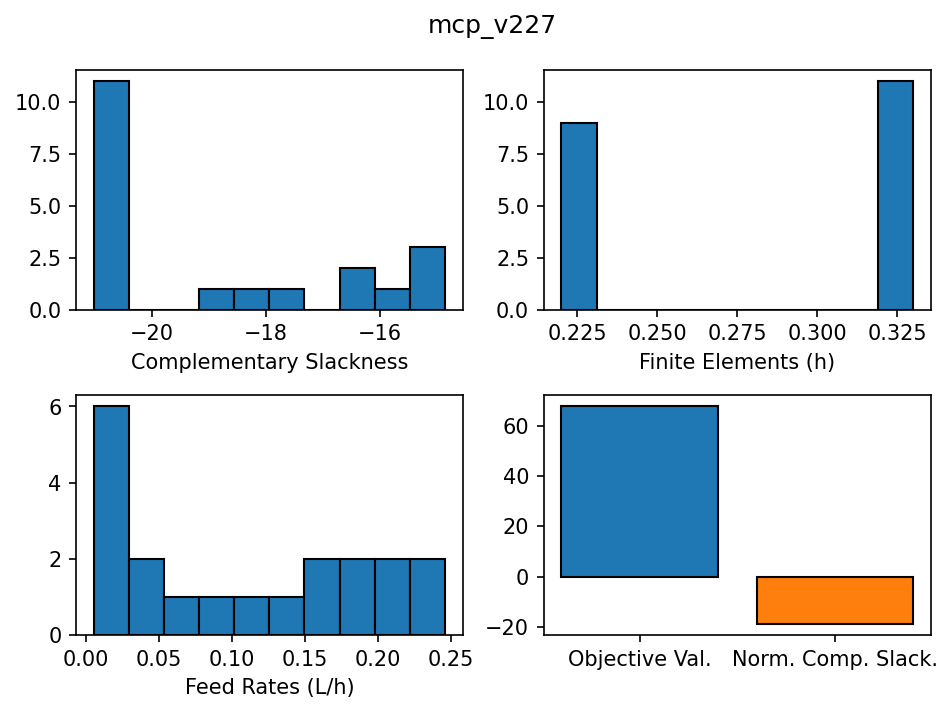

In [53]:
plt.suptitle(dirname)

plt.subplot(221)
plt.xlabel("Complementary Slackness")
plt.hist(sum_dic["Complementary Slackness per CTRL interval"][0],edgecolor='k')

plt.subplot(222)
plt.hist(sum_dic["Control Intervals"][0],edgecolor='k')
plt.xlabel("Finite Elements (h)")

plt.subplot(223)
plt.hist(sum_dic["Feed Rates"][0],edgecolor="k")
plt.xlabel("Feed Rates (L/h)")

plt.subplot(224)
plt.bar(1,sum_dic["Objective Value"][0],edgecolor='k')
plt.bar(2,sum_dic["Normalized Complementary Slackness"][0],edgecolor='k')
plt.xticks([1,2],["Objective Val.", "Norm. Comp. Slack."])

plt.tight_layout()
plt.show()

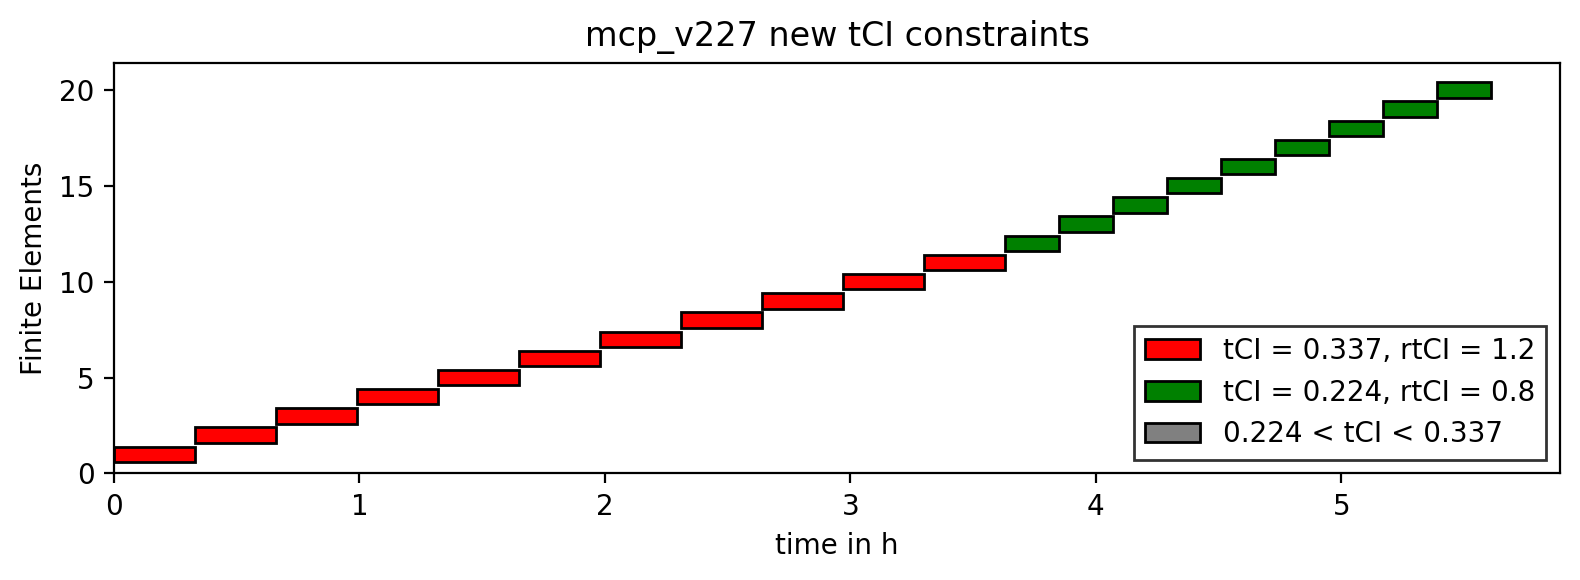

In [54]:
with open("simulations/"+dirname+".jl","r") as file:
    lines = file.readlines()

# find the (r)tCI bounds
old_implementation = 0
new_implementation = 0
# except if the bounds are no numbers, but fixed to variables
unknown_bounds = False
try:
    for line in lines:
        if "set_" in line and "_bound" in line and "(tCI" in line:
            if "_lower_" in line:
                lb_tCI = float(line.split(",")[1].strip(")\n"))
                old_implementation += 1
            elif "_upper" in line:
                ub_tCI = float(line.split(",")[1].strip(")\n"))
                old_implementation += 1
            else:
                print("MÖÖP")
        if "set_" in line and "_bound" in line and "(rtCI" in line:
            if "_lower_" in line:
                lb_rtCI = float(line.split(",")[1].strip(")\n"))
                lb_tCI  = lb_rtCI*np.sum(sum_dic["Control Intervals"])/len(sum_dic["Control Intervals"][0])
                new_implementation += 1
            elif "_upper" in line:
                ub_rtCI = float(line.split(",")[1].strip(")\n"))
                ub_tCI  = ub_rtCI*np.sum(sum_dic["Control Intervals"])/len(sum_dic["Control Intervals"][0])
                new_implementation += 1
            else:
                print("MÖÖP")
except:
    unknown_bounds = True
    lb_tCI = np.nan
    ub_tCI = np.nan
    

#print(lb_tCI, "<= tCI <=",ub_tCI)

cols = []
for bla in sum_dic["Control Intervals"][0]:
    if np.isclose(bla,lb_tCI,1e-1):
        cols.append("g")
    elif np.isclose(bla,ub_tCI,1e-1):
        cols.append("r")
    else:
        cols.append("grey")
        
plt.figure(dpi=200,figsize=(8,3))
h = [i+1 for i in range(len(sum_dic["Control Intervals"][0]))]
b = [np.sum(sum_dic["Control Intervals"][0][:i]) for i in range(len(sum_dic["Control Intervals"][0]))]
plt.barh(h,width=sum_dic["Control Intervals"][0],left=b,edgecolor='k',color=cols)

if old_implementation == 2:
    plt.title(dirname+" old tCI constraints")
    plt.bar(3,0,color="r",label=f"tCI = {ub_tCI}",edgecolor='k')
    plt.bar(3,0,color="g",label=f"tCI = {lb_tCI}",edgecolor='k')
    plt.bar(3,0,color="gray",label=f"{lb_tCI} < tCI < {ub_tCI}",edgecolor='k')
elif new_implementation == 2:
    plt.title(dirname+" new tCI constraints")
    plt.bar(3,0,color="r",label=f"tCI = {ub_tCI:.3f}, rtCI = {ub_rtCI:.1f}",edgecolor='k')
    plt.bar(3,0,color="g",label=f"tCI = {lb_tCI:.3f}, rtCI = {lb_rtCI:.1f}",edgecolor='k')
    plt.bar(3,0,color="gray",label=f"{lb_tCI:.3f} < tCI < {ub_tCI:.3f}",edgecolor='k')
elif unknown_bounds:
    plt.bar(3,0,color="gray",label=r"$var_{1,i}$ < tCI < $var_{2,i}$",edgecolor='k')
else:
    print("there is some problem")
    

plt.legend(loc="lower right")
plt.ylabel("Finite Elements")
plt.xlabel("time in h")

plt.tight_layout()
plt.show()

## Plot Process Variables

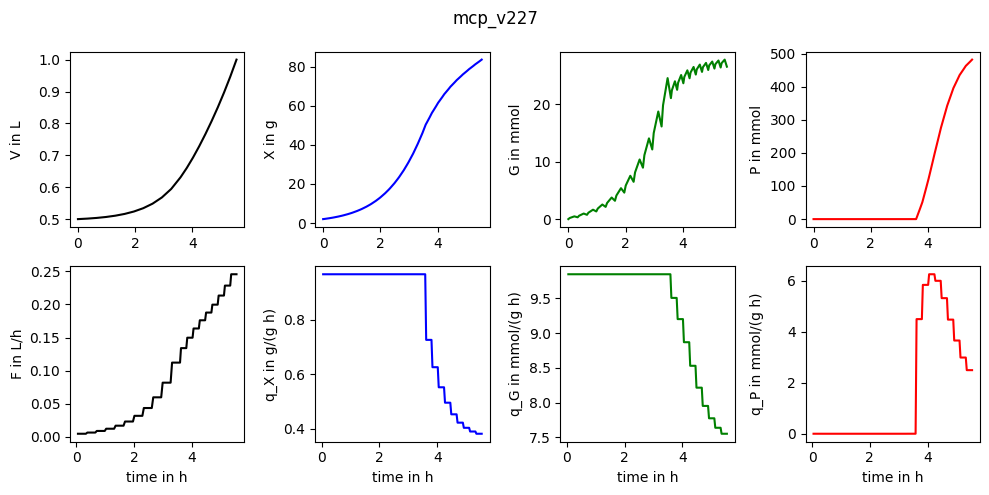

In [55]:
df = pd.read_csv("simulations/"+dirname+"/df.csv")

fig = plt.figure(dpi=100,figsize=(10,5))
axes = []
for i in range(8):
    ax = fig.add_subplot(2,4,i+1)
    axes.append(ax)

axes[0].plot(df.t,df.V,color="k")
axes[1].plot(df.t,df.X/df.V,color="b")
axes[2].plot(df.t,df.G/df.V,color="g")
axes[3].plot(df.t,df.P/df.V,color="r")

axes[4].plot(df.t,df.r_V,color="k")
axes[5].plot(df.t,df.q_X,color="b")
axes[6].plot(df.t,-df.q_G,color="g")
axes[7].plot(df.t,df.q_P,color="r")

axes[0].set_ylabel("V in L")
axes[1].set_ylabel("X in g")
axes[2].set_ylabel("G in mmol")
axes[3].set_ylabel("P in mmol")
axes[4].set_ylabel("F in L/h")
axes[5].set_ylabel("q_X in g/(g h)")
axes[6].set_ylabel("q_G in mmol/(g h)")
axes[7].set_ylabel("q_P in mmol/(g h)")

for ax in axes[4:]:
    ax.set_xlabel("time in h")

fig.suptitle(dirname)
fig.align_ylabels()
plt.tight_layout()

plt.show()

## Production Envelopes

### Linear Toxicity

Set rate_collocation_point to 2.


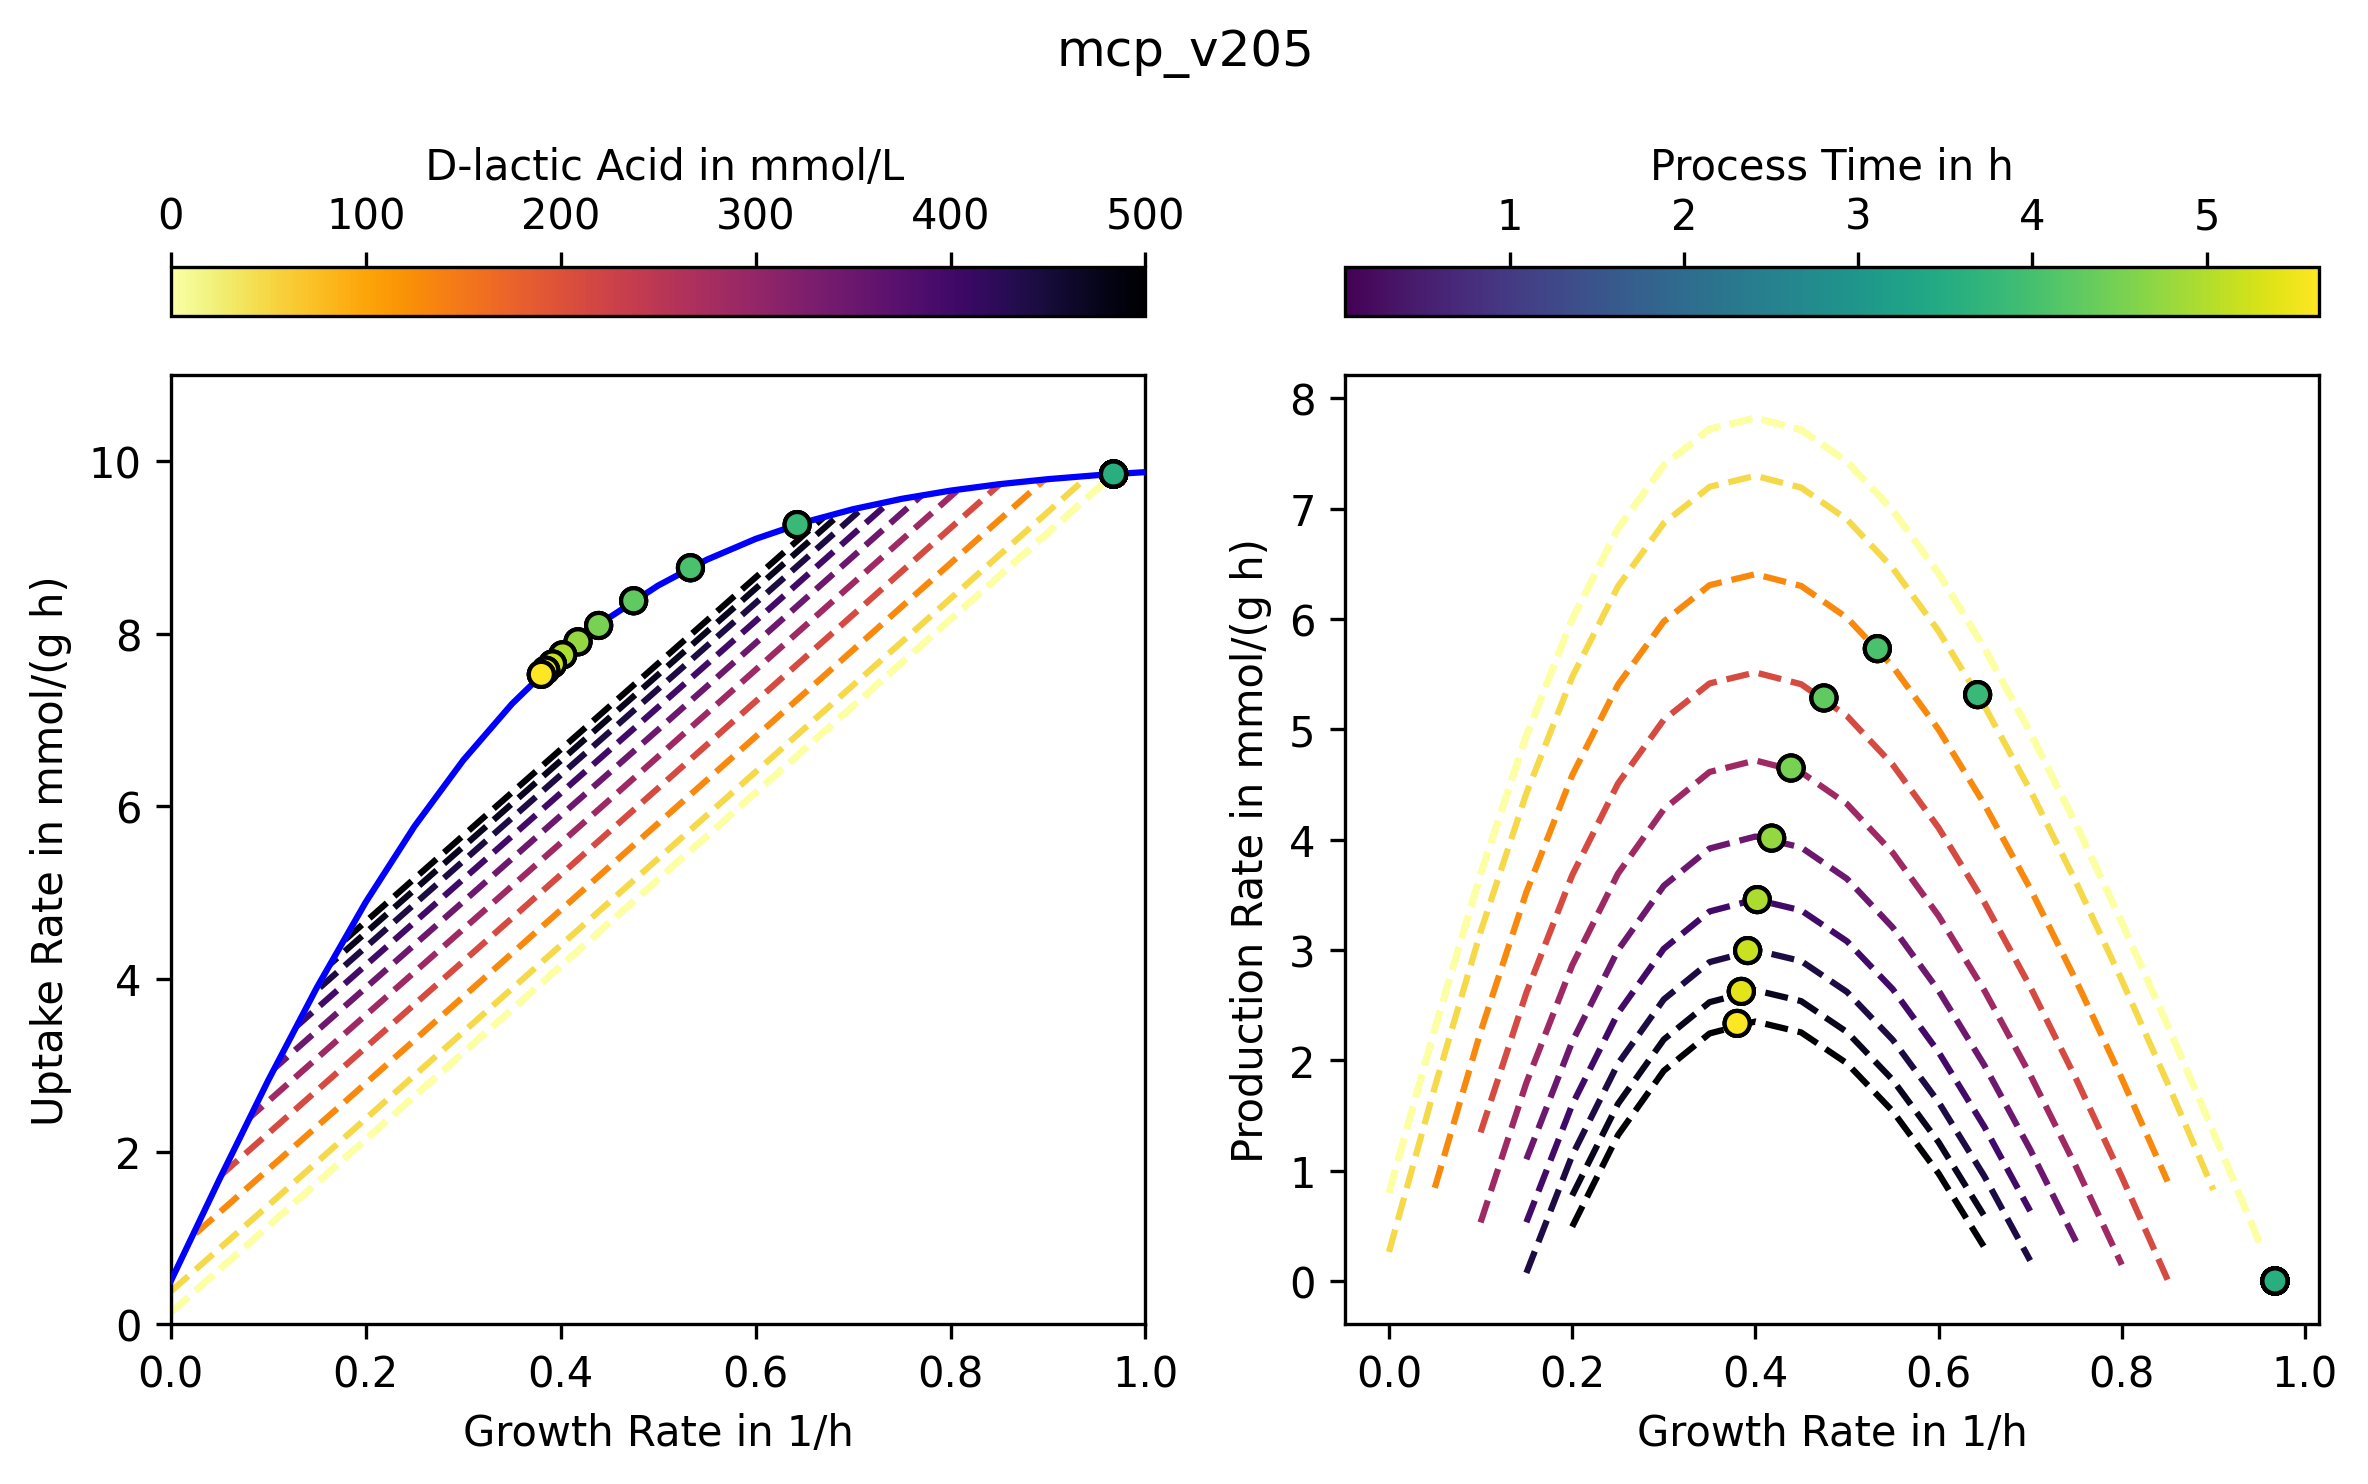

In [44]:
def rev_HH(conc_tot,pH=7,pKa=3.86):
    conc_HA = conc_tot/(1 + 10**(pH-pKa))
    return conc_HA

with open("simulations/"+dirname+".jl","r") as file:
    lines = file.readlines()
    
rate_collocation_point = False
for line in lines:
    if "q_M[i=1:nCI]" in line and "kATPM" in line:
        loc1 = line.find("(N")
        loc2 = line.find("/V")
        rate_collocation_point = int(line[loc1:loc2].split(",")[2].strip("]"))
        print(f"Set rate_collocation_point to {rate_collocation_point}.")
        break
if rate_collocation_point == False:
        print("Rate calculation collocation point not found. Set to default, i.e., 2.")
        rate_collocation_point = 2

# every 3rd collocation point
df = pd.read_csv("simulations/"+dirname+"/df.csv")
df2 = df.iloc[rate_collocation_point:,:].iloc[::3,:]

qX = np.linspace(0,1,21)
qG = get_qG(qX)


linX = [qX[0],qX[-1]]
linY = [qG[0],qG[-1]]

plt.figure(dpi=300,figsize=(8,5))
plt.suptitle(dirname)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(qX,qG,zorder=3,color='blue') #,color=cm.viridis((tmp_k-np.min(k_range))/(10-np.min(k_range))),zorder=0)
ax1.fill_between(qX,np.ones(len(qX))*11,qG,color='w',zorder=2)

conc_list = df2.P.values/df2.V.values
with ecoli as tmp:
    for c in conc_list:
        tmp_conc_lacH = rev_HH(c)
        k = 196.15209181
        ATPM_base_value = 3.15
        snek.set_bounds(tmp,"ATPM",lb=ATPM_base_value+k*tmp_conc_lacH,ub=1000)
#        print(ATPM_base_value+k*tmp_conc_lacH)
        min_qX = np.linspace(0,1,21)
        min_qG = []
        for qX_ in min_qX:
            snek.set_bounds(tmp,"BIOMASS_Ec_iJO1366_core_53p95M",qX_,qX_)
            snek.set_bounds(tmp,"EX_glc__D_e",lb=-1000,ub=0)
#            snek.set_objective(tmp,"EX_glc__D_e","max")
            tmp.objective = "EX_glc__D_e"
            tmp.objective_direction = "max"
            sol = tmp.slim_optimize()
            tmp_qG = -sol #["EX_glc__D_e"]
            min_qG.append(tmp_qG)
        min_qG = np.array(min_qG)
        ax1.plot(min_qX,min_qG,color=cm.inferno_r(c/np.max(conc_list)),linestyle="dashed",zorder=1)
        
        feasible_qG = qG[min_qG <= qG]
        feasible_qX = qX[min_qG <= qG]
        feasible_qP = []
        for qG_,qX_ in zip(feasible_qG,feasible_qX):
            snek.set_bounds(tmp,"BIOMASS_Ec_iJO1366_core_53p95M",qX_,qX_)
            snek.set_bounds(tmp,"EX_glc__D_e",-qG_,-qG_)
            snek.set_bounds(tmp,"EX_lac__D_e",0,1000)
            snek.set_objective(tmp,"EX_lac__D_e","max")
            qP_ = tmp.slim_optimize()
            feasible_qP.append(qP_)
        ax2.plot(feasible_qX,feasible_qP,color=cm.inferno_r(c/np.max(conc_list)),linestyle="dashed",zorder=1)
            
ax1.scatter(df.q_X,-df.q_G,c=df.t,edgecolor='k',zorder=5,label="Simulation")
sc = ax2.scatter(df.q_X,df.q_P,c=df.t,edgecolor='k',zorder=5,label="Simulation")
plt.colorbar(sc,ax=ax2,label="Process Time in h",location="top")

cb = plt.colorbar(cm.ScalarMappable(cmap=cm.inferno_r),ax=ax1,label=" D-lactic Acid in mmol/L",location="top")
conc_list = np.linspace(0,500,6)
cb.set_ticks(conc_list/np.max(conc_list))
cb.set_ticklabels([int(i) for i in conc_list])
ax1.set_xlabel("Growth Rate in 1/h")
ax2.set_xlabel("Growth Rate in 1/h")
ax1.set_ylabel("Uptake Rate in mmol/(g h)")
ax2.set_ylabel("Production Rate in mmol/(g h)")
#plt.axhline(10)
ax1.set_xlim(0,1)
ax1.set_ylim(0,11)
plt.tight_layout()
plt.show()

### Quadratic Toxicity

Set rate_collocation_point to 2.


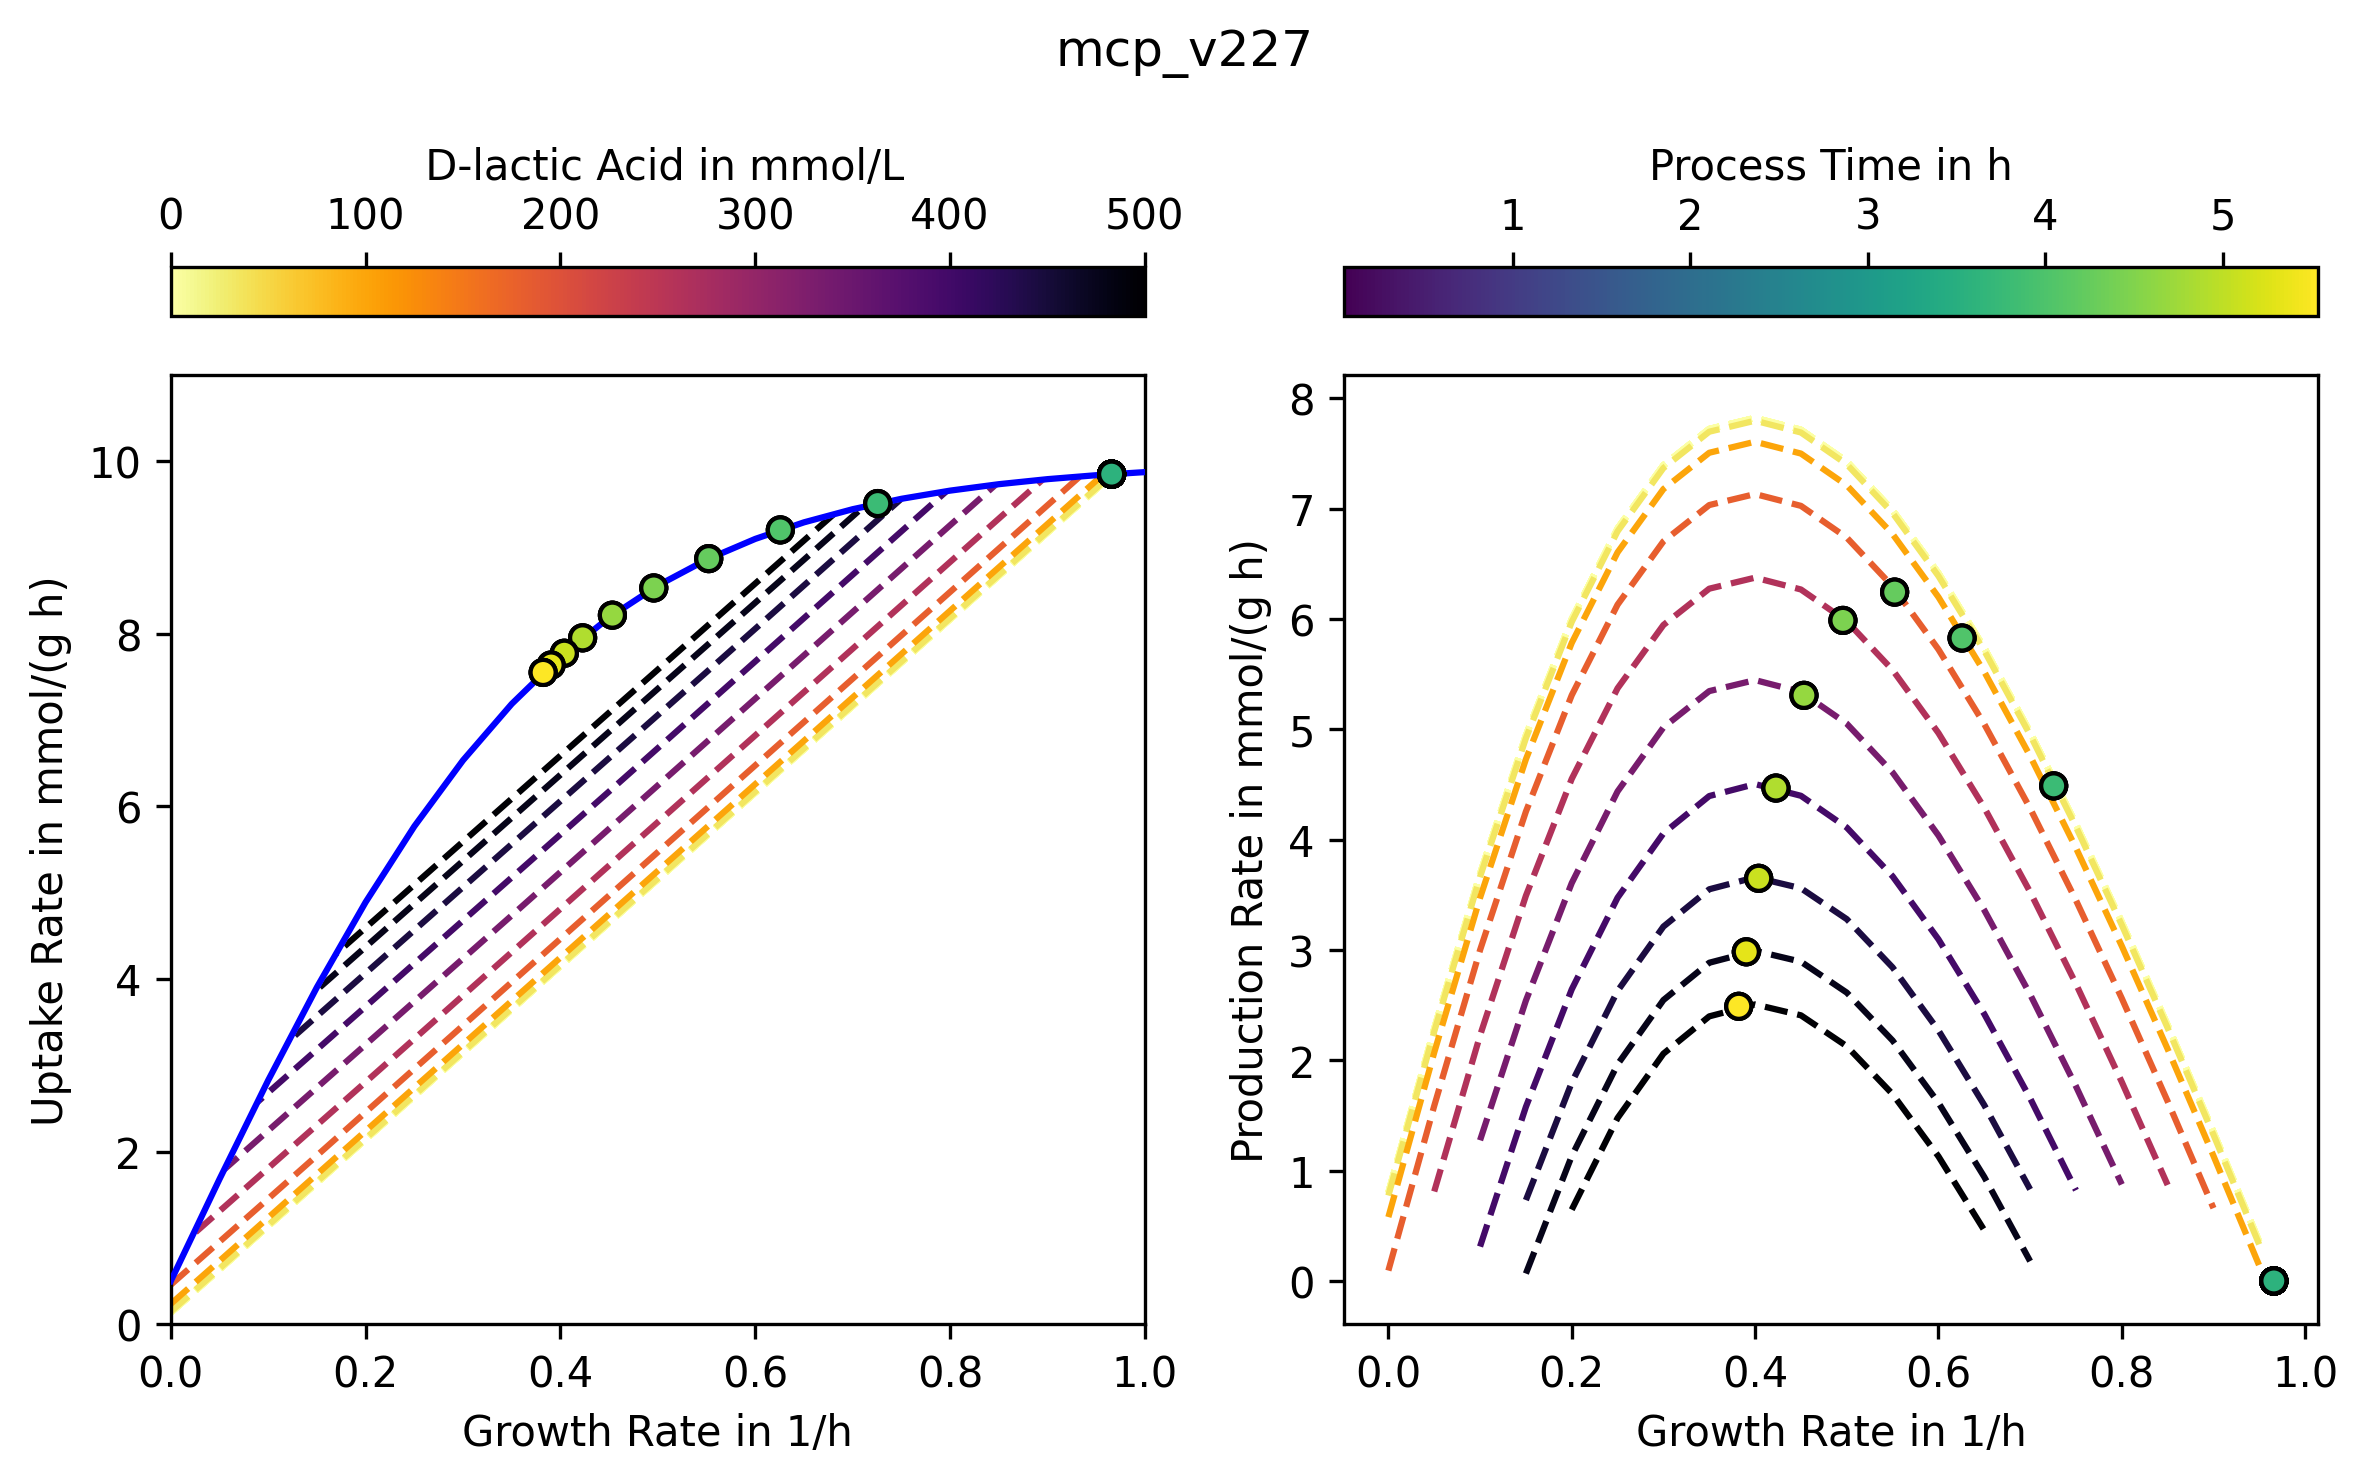

In [56]:
def rev_HH(conc_tot,pH=7,pKa=3.86):
    conc_HA = conc_tot/(1 + 10**(pH-pKa))
    return conc_HA

with open("simulations/"+dirname+".jl","r") as file:
    lines = file.readlines()
    
rate_collocation_point = False
for line in lines:
    if "q_M[i=1:nCI]" in line and "kATPM" in line:
        loc1 = line.find("(N")
        loc2 = line.find("/V")
        rate_collocation_point = int(line[loc1:loc2].split(",")[2].strip("]"))
        print(f"Set rate_collocation_point to {rate_collocation_point}.")
        break
if rate_collocation_point == False:
        print("Rate calculation collocation point not found. Set to default, i.e., 2.")
        rate_collocation_point = 2

# every 3rd collocation point
df = pd.read_csv("simulations/"+dirname+"/df.csv")
df2 = df.iloc[rate_collocation_point:,:].iloc[::3,:]

qX = np.linspace(0,1,21)
qG = get_qG(qX)


linX = [qX[0],qX[-1]]
linY = [qG[0],qG[-1]]

plt.figure(dpi=300,figsize=(8,5))
plt.suptitle(dirname)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(qX,qG,zorder=3,color='blue') #,color=cm.viridis((tmp_k-np.min(k_range))/(10-np.min(k_range))),zorder=0)
ax1.fill_between(qX,np.ones(len(qX))*11,qG,color='w',zorder=2)

conc_list = df2.P.values/df2.V.values
with ecoli as tmp:
    for c in conc_list:
        tmp_conc_lacH = rev_HH(c)
        k = 490.81318912
        ATPM_base_value = 3.15
        snek.set_bounds(tmp,"ATPM",lb=ATPM_base_value+k*tmp_conc_lacH**2,ub=1000)
#        print(ATPM_base_value+k*tmp_conc_lacH)
        min_qX = np.linspace(0,1,21)
        min_qG = []
        for qX_ in min_qX:
            snek.set_bounds(tmp,"BIOMASS_Ec_iJO1366_core_53p95M",qX_,qX_)
            snek.set_bounds(tmp,"EX_glc__D_e",lb=-1000,ub=0)
#            snek.set_objective(tmp,"EX_glc__D_e","max")
            tmp.objective = "EX_glc__D_e"
            tmp.objective_direction = "max"
            sol = tmp.slim_optimize()
            tmp_qG = -sol #["EX_glc__D_e"]
            min_qG.append(tmp_qG)
        min_qG = np.array(min_qG)
        ax1.plot(min_qX,min_qG,color=cm.inferno_r(c/np.max(conc_list)),linestyle="dashed",zorder=1)
        
        feasible_qG = qG[min_qG <= qG]
        feasible_qX = qX[min_qG <= qG]
        feasible_qP = []
        for qG_,qX_ in zip(feasible_qG,feasible_qX):
            snek.set_bounds(tmp,"BIOMASS_Ec_iJO1366_core_53p95M",qX_,qX_)
            snek.set_bounds(tmp,"EX_glc__D_e",-qG_,-qG_)
            snek.set_bounds(tmp,"EX_lac__D_e",0,1000)
            snek.set_objective(tmp,"EX_lac__D_e","max")
            qP_ = tmp.slim_optimize()
            feasible_qP.append(qP_)
        ax2.plot(feasible_qX,feasible_qP,color=cm.inferno_r(c/np.max(conc_list)),linestyle="dashed",zorder=1)
            
ax1.scatter(df.q_X,-df.q_G,c=df.t,edgecolor='k',zorder=5,label="Simulation")
sc = ax2.scatter(df.q_X,df.q_P,c=df.t,edgecolor='k',zorder=5,label="Simulation")
plt.colorbar(sc,ax=ax2,label="Process Time in h",location="top")

cb = plt.colorbar(cm.ScalarMappable(cmap=cm.inferno_r),ax=ax1,label=" D-lactic Acid in mmol/L",location="top")
conc_list = np.linspace(0,500,6)
cb.set_ticks(conc_list/np.max(conc_list))
cb.set_ticklabels([int(i) for i in conc_list])
ax1.set_xlabel("Growth Rate in 1/h")
ax2.set_xlabel("Growth Rate in 1/h")
ax1.set_ylabel("Uptake Rate in mmol/(g h)")
ax2.set_ylabel("Production Rate in mmol/(g h)")
#plt.axhline(10)
ax1.set_xlim(0,1)
ax1.set_ylim(0,11)
plt.tight_layout()
plt.show()

# Compare Runs with Toxicity

Process              | P       | P/t     | P/V     | P/Gfed  | CSP    
                     | mmol    | mmol/h  | mmol/L  | mol/mol |        
1SP                  |  443.93 |   60.22 |  443.93 |    0.36 |    1.92
O2SP                 |  490.46 |   84.44 |  490.46 |    0.39 |    2.35
MSP                  |  481.54 |   86.97 |  481.54 |    0.39 |    2.36


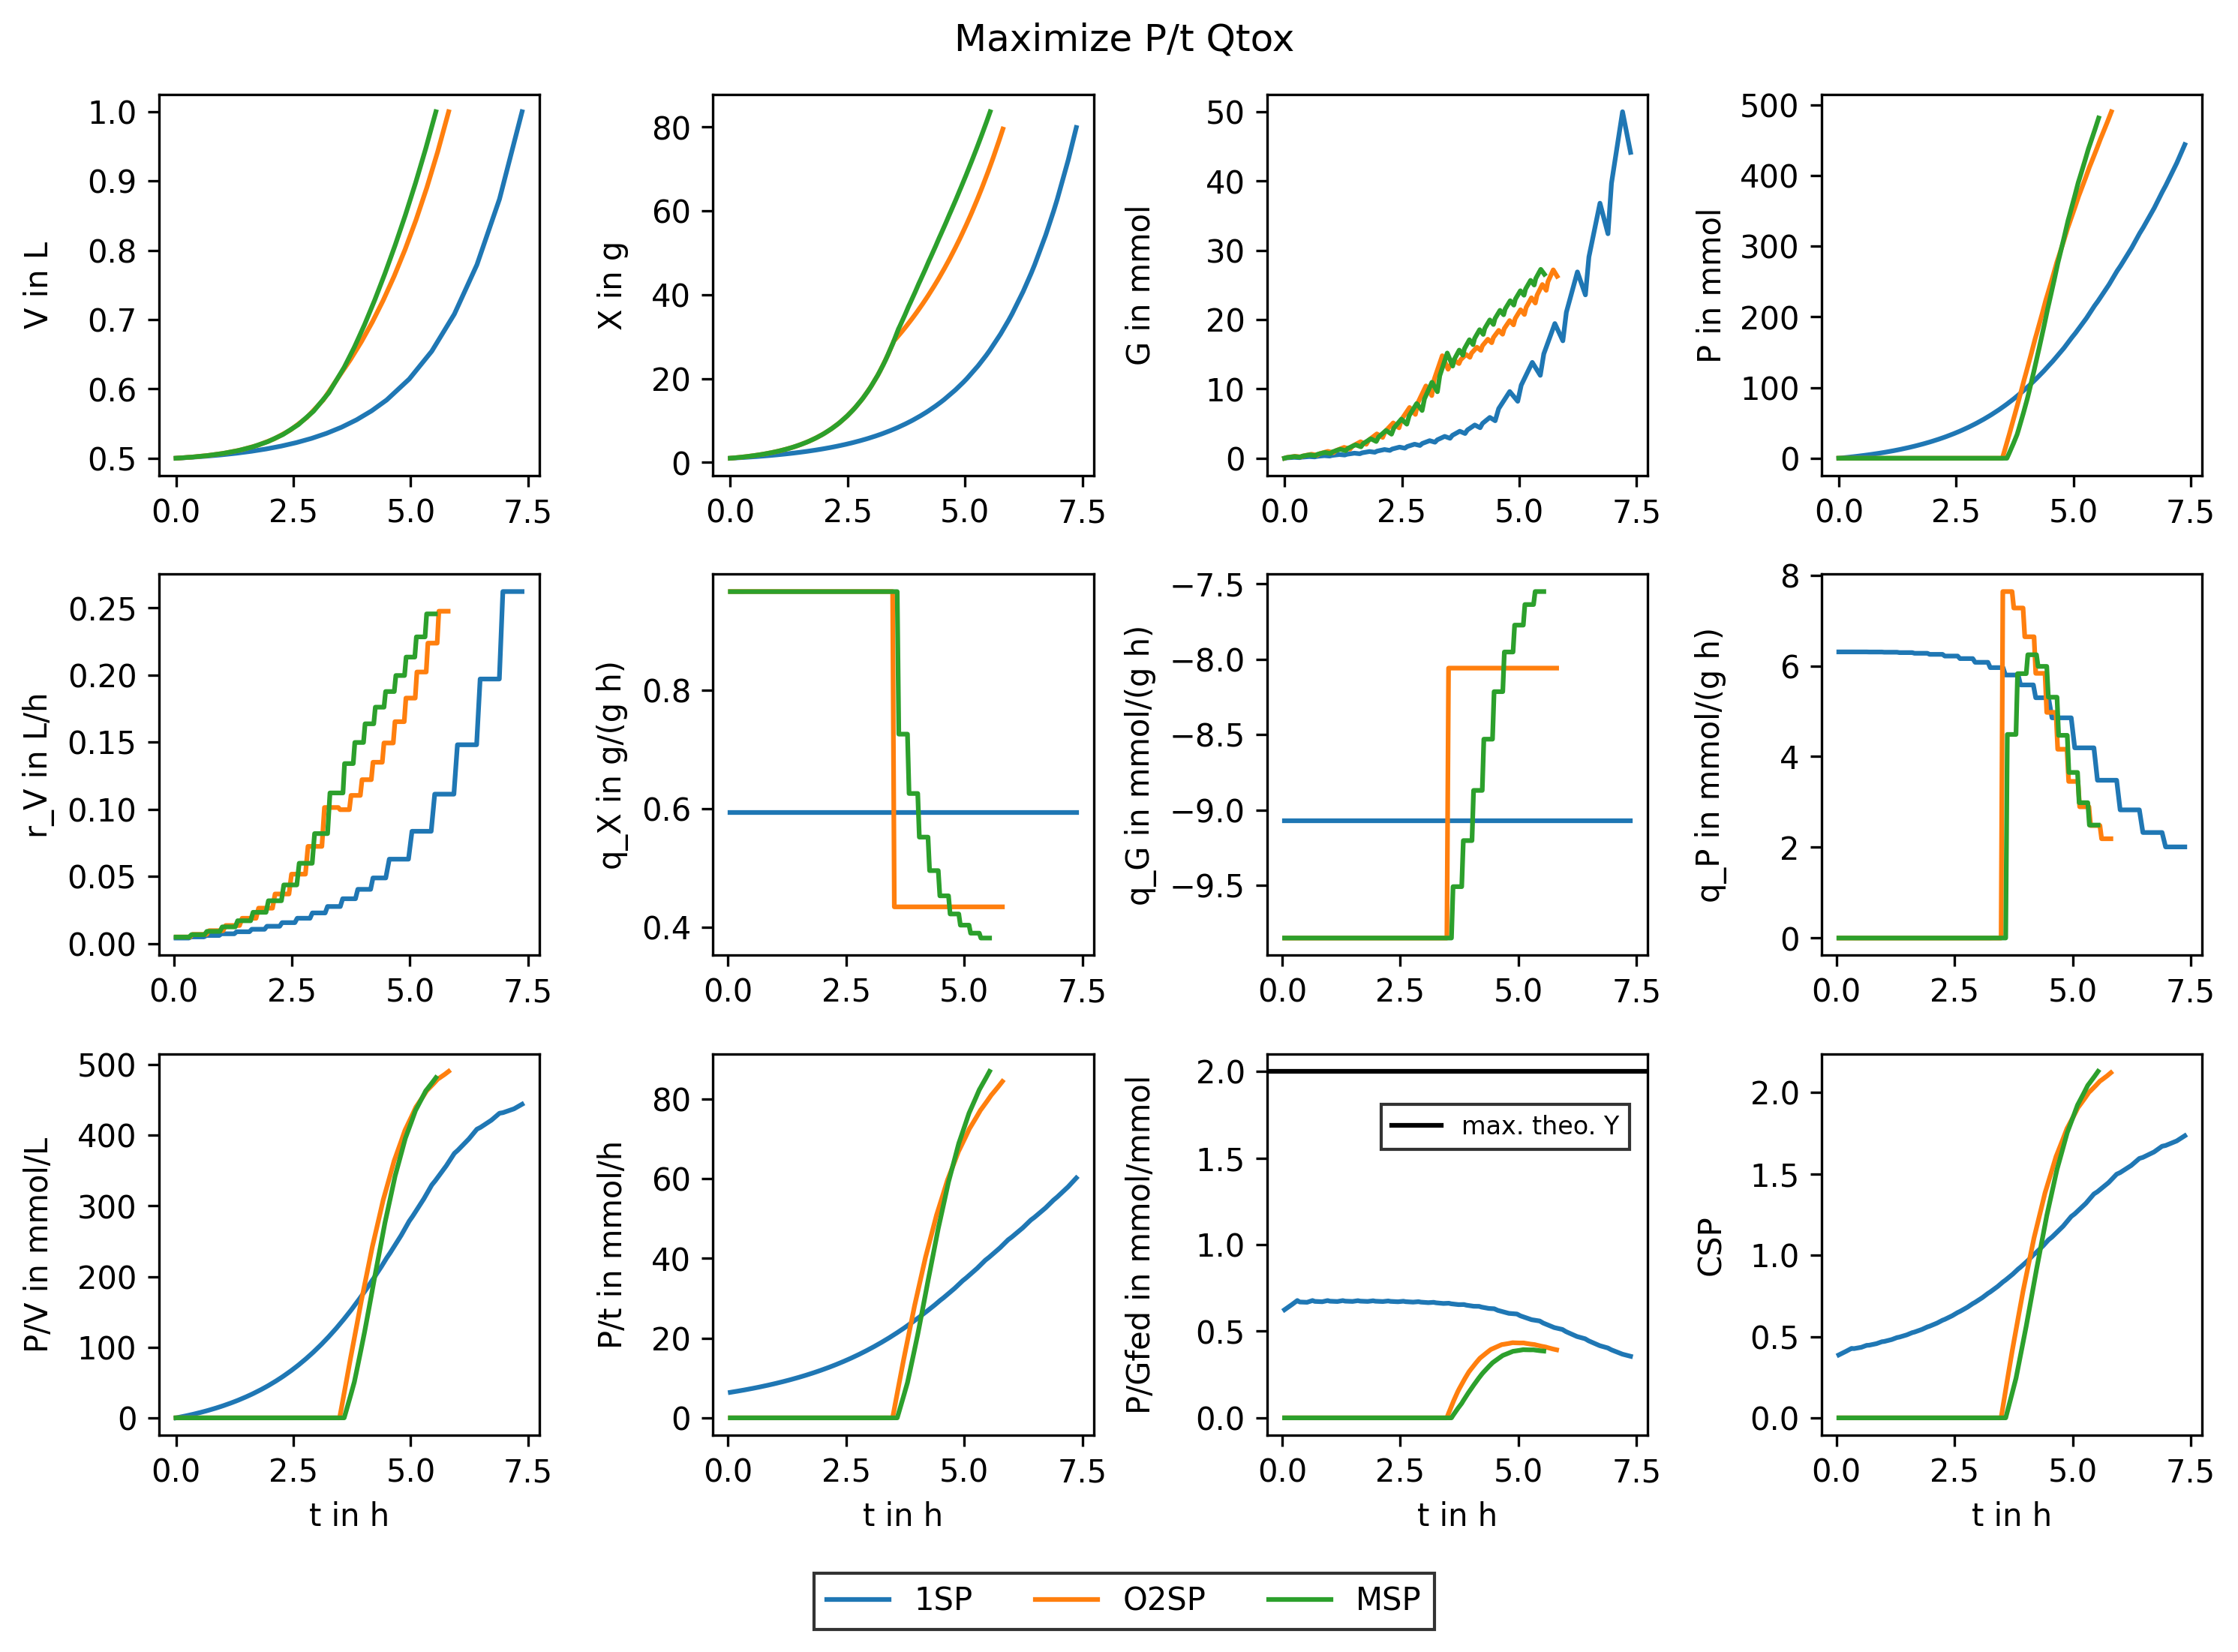

In [70]:
# fixed toxicity, max P
supt = "Maximize End Product"
sims = ["mcp_v203","mcp_v202","mcp_v201"]
labs = ["1SP","O2SP","MSP"]

if 1:
    # fixed toxicity, max CSP
    supt = "Maximize CSP"
    sims = ["mcp_v221","mcp_v222","mcp_v206"]
    labs = ["1SP","O2SP","MSP"]
    
if 1:
    # fixed lin toxicity, max P/t
    supt = "Maximize P/t Ltox"
    sims = ["mcp_v233","mcp_v232","mcp_v205"]
    labs = ["1SP","O2SP","MSP"]
    
if 1:
    # fixed quad toxicity, max P/t
    supt = "Maximize P/t Qtox"
    sims = ["mcp_v231","mcp_v230","mcp_v227"]
    labs = ["1SP","O2SP","MSP"]

if 0:
    # max P/V max P/t
    supt = "Runs for Calculation of CSP"
    sims = ["mcp_v204","mcp_v205","mcp_v206"]
    labs = ["Max. P/V","Max. P/t","Max. CSP"]
    
if 0:
    # max P/V max P/t quadratic toxicity
    supt = "Runs for Calculation of CSP -- Quadratic Toxicity"
    sims = ["mcp_v228","mcp_v227","mcp_v229"]
    labs = ["Max. P/V","Max. P/t","Max. CSP"]

if 0:
    # max P/t
    supt = "Max P/t -- Different Toxicity Functions"
    sims = ["mcp_v205","mcp_v227"]
    labs = ["Linear","Quadratic"]
    
if 0:
    # max P
    supt = "Max P -- Different Toxicity Functions"
    sims = ["mcp_v200","mcp_v225"]
    labs = ["Linear","Quadratic"]


c_G = 450/0.18015588 # g/L /(g/mmol) = mmol/L # basically max solubility

fig = plt.figure(dpi=300,figsize=(10,7))
plt.suptitle(supt)
axes = []
for i in range(12):
    axes.append(plt.subplot(3,4,i+1))
    
print(f"{'Process':20} | {'P':7} | {'P/t':7} | {'P/V':7} | {'P/Gfed':7} | {'CSP':7}")
print(f"{' ':20} | {'mmol':7} | {'mmol/h':7} | {'mmol/L':7} | {'mol/mol':7} | {'':7}")
for sim,lab in zip(sims,labs):
    df = pd.read_csv("simulations/"+sim+"/df.csv")
    status = get_tox_status(sim,verbose=False)
    if status == "L":
        maxP  = 471.32
        maxPt = 75.61
        maxPG = 2
    elif status == "Q":
        maxP  = 513.71
        maxPt = 86.97
        maxPG = 2
    axes[0].plot(df.t,df.V)
    axes[1].plot(df.t,df.X)
    axes[2].plot(df.t,df.G)
    axes[3].plot(df.t,df.P)
    axes[4].plot(df.t,df.r_V)
    axes[5].plot(df.t,df.q_X)
    axes[6].plot(df.t,df.q_G)
    axes[7].plot(df.t,df.q_P)
    axes[8].plot(df.t,df.P/df.V)
    axes[9].plot(df.t,df.P/df.t)
    axes[10].plot(df.t,df.P/((df.V-0.5)*c_G))
    all_CSP = df.P/df.V/maxP + df.P/df.t/maxPt + df.P/((df.V-0.5)*c_G)/maxPG
    axes[11].plot(df.t,all_CSP,label=lab)
    tmp_P = df.P.values[-1]
    tmp_Pt = df.P.values[-1]/df.t.values[-1]
    tmp_PV = df.P.values[-1]/df.V.values[-1]
    tmp_PG = df.P.values[-1]/((df.V.values[-1]-0.5)*c_G)
    tmp_CSP = tmp_PV/471.32 + tmp_Pt/75.61 + tmp_PG/2
    print(f"""{lab:20} | {tmp_P:>7.2f} | {tmp_Pt:7.2f} | {tmp_PV:7.2f} | {tmp_PG:7.2f} | {tmp_CSP:7.2f}""")

axes[0].set_ylabel('V in L')
axes[1].set_ylabel('X in g')
axes[2].set_ylabel('G in mmol')
axes[3].set_ylabel('P in mmol')
axes[4].set_ylabel('r_V in L/h')
axes[5].set_ylabel('q_X in g/(g h)')
axes[6].set_ylabel('q_G in mmol/(g h)')
axes[7].set_ylabel('q_P in mmol/(g h)')
axes[8].set_ylabel('P/V in mmol/L')
axes[9].set_ylabel('P/t in mmol/h')
axes[10].set_ylabel('P/Gfed in mmol/mmol')
axes[11].set_ylabel('CSP')

fig.legend(loc="lower center",ncol=6,bbox_to_anchor=(.5,-.05))

axes[10].axhline(2,label="max. theo. Y",color='k',zorder=10)
axes[10].legend(fontsize=8,loc=(.3,.75))

for ax in axes[8:]:
    ax.set_xlabel('t in h')

fig.align_ylabels()
plt.tight_layout()
plt.show()

In [65]:
def get_tox_status(dirname,verbose=True):
    # get summary
    with open("simulations/"+dirname+".jl","r") as file:
        lines = file.readlines()

    status = None
    for line in lines:
        if "196.15209181" in line:
            status = "L"
            break
        elif "490.81318912" in line:
            status = "Q"
            break
    if verbose:
        print("Set tox status to",status)
    return status

## different nCI

Process              | P       | P/t     | P/V     | P/Gfed  | CSP     | Time   
                     | mmol    | mmol/h  | mmol/L  | mol/mol |         | min    
mcp_v212           5 |  444.33 |   74.46 |  444.33 |   0.356 |   2.105 |   0.782
mcp_v211          10 |  445.01 |   73.17 |  445.01 |   0.356 |   2.090 |   1.909
mcp_v209          15 |  446.41 |   73.54 |  446.41 |   0.357 |   2.098 |   3.273
mcp_v208          20 |  447.14 |   73.79 |  447.14 |   0.358 |   2.104 |   5.414
mcp_v207          30 |  447.09 |   74.24 |  447.09 |   0.358 |   2.110 |  10.102
mcp_v210          35 |  447.56 |   74.27 |  447.56 |   0.358 |   2.111 |  10.123
mcp_v213          40 |  448.08 |   74.24 |  448.08 |   0.359 |   2.112 |  14.336
mcp_v220          60 |  447.20 |   74.38 |  447.20 |   0.358 |   2.112 |  14.347
mcp_v223          80 |  447.66 |   74.32 |  447.66 |   0.358 |   2.112 |  20.554
mcp_v224         100 |  447.69 |   74.29 |  447.69 |   0.358 |   2.112 |  29.938


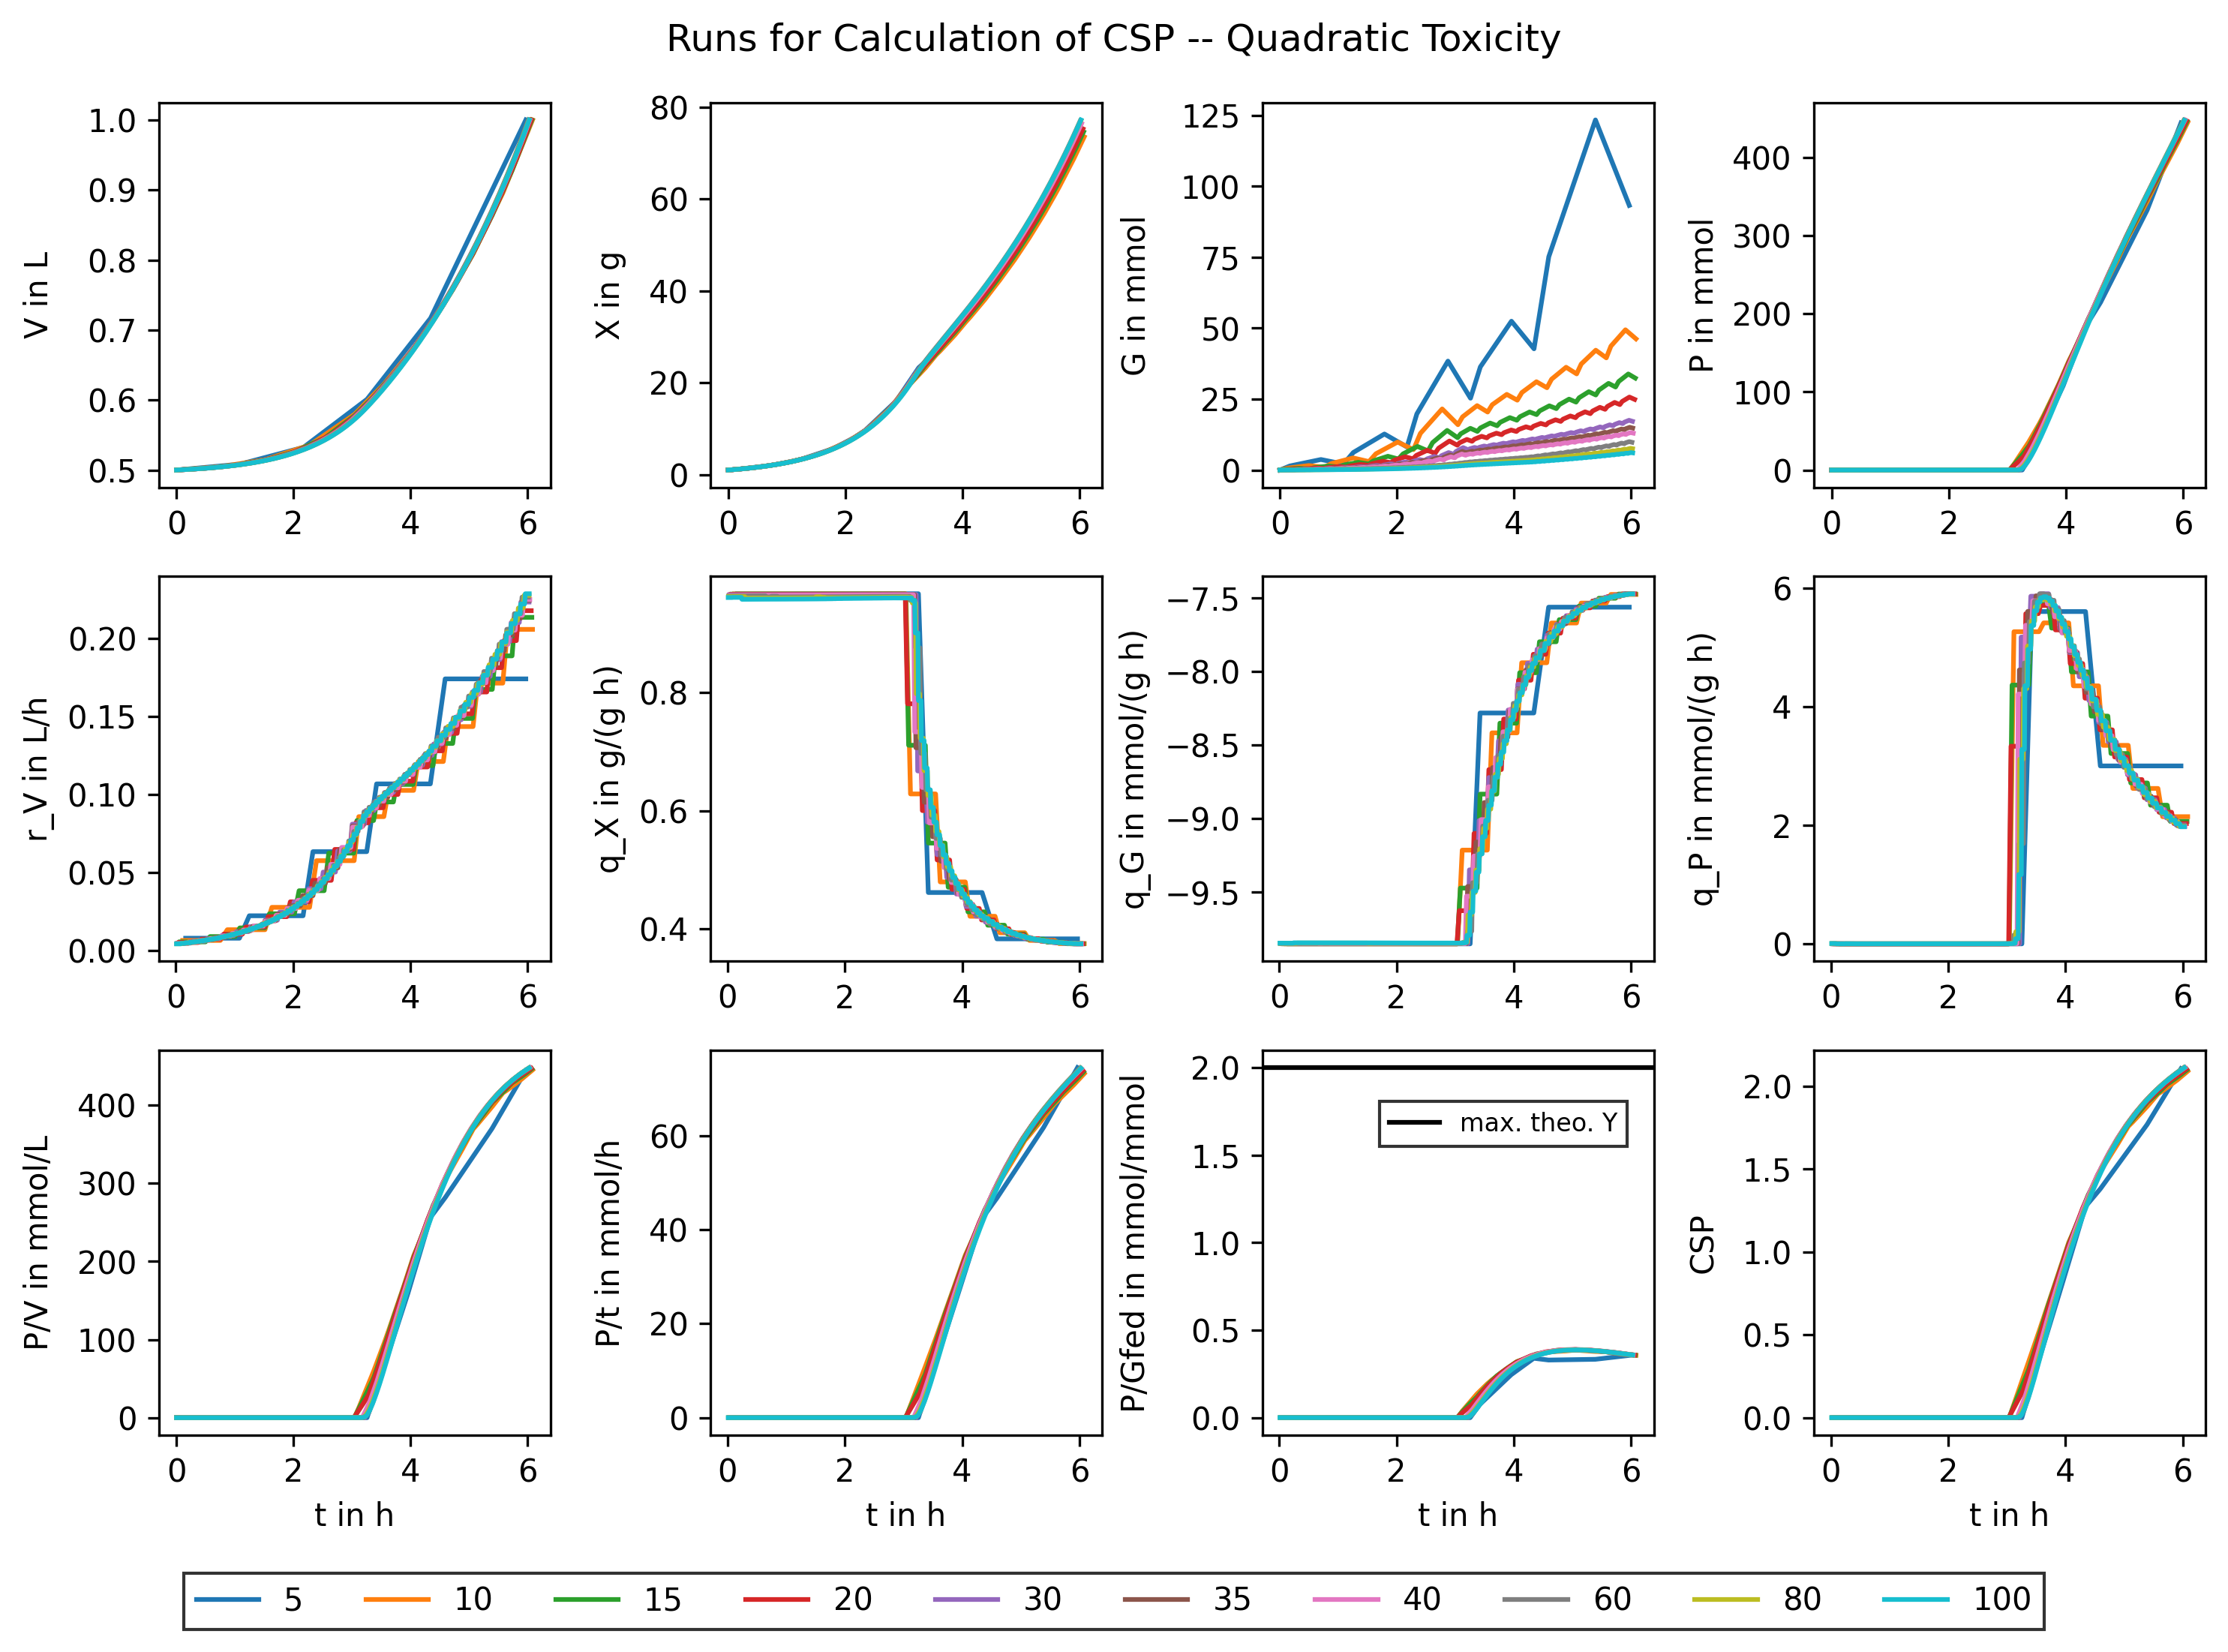

In [14]:
# 2nd CP for rate calculation
sims = ["mcp_v212","mcp_v211","mcp_v209","mcp_v208","mcp_v207","mcp_v210","mcp_v213","mcp_v220","mcp_v223","mcp_v224"]

# 3rd CP for rate calculation
# sims = ["mcp_v216","mcp_v218","mcp_v214","mcp_v215"]

labs = []
times = []
for sim in sims:
    sum_dic, sum_df = parse_summary_file(sim)
    labs.append(len(sum_dic["Control Intervals"][0]))
    times.append(sum_dic["Time Elapsed in min"][0])
    
c_G = 450/0.18015588 # g/L /(g/mmol) = mmol/L # basically max solubility

fig = plt.figure(dpi=300,figsize=(10,7))
plt.suptitle(supt)
axes = []
for i in range(12):
    axes.append(plt.subplot(3,4,i+1))
    
print(f"{'Process':20} | {'P':7} | {'P/t':7} | {'P/V':7} | {'P/Gfed':7} | {'CSP':7} | {'Time':7}")
print(f"{' ':20} | {'mmol':7} | {'mmol/h':7} | {'mmol/L':7} | {'mol/mol':7} | {'':7} | {'min':7}")
for sim,lab,time in zip(sims,labs,times):
    df = pd.read_csv("simulations/"+sim+"/df.csv")
    axes[0].plot(df.t,df.V)
    axes[1].plot(df.t,df.X)
    axes[2].plot(df.t,df.G)
    axes[3].plot(df.t,df.P)
    axes[4].plot(df.t,df.r_V)
    axes[5].plot(df.t,df.q_X)
    axes[6].plot(df.t,df.q_G)
    axes[7].plot(df.t,df.q_P)
    axes[8].plot(df.t,df.P/df.V)
    axes[9].plot(df.t,df.P/df.t)
    axes[10].plot(df.t,df.P/((df.V-0.5)*c_G))
    all_CSP = df.P/df.V/471.32 + df.P/df.t/75.61 + df.P/((df.V-0.5)*c_G)/2
    axes[11].plot(df.t,all_CSP,label=lab)
    tmp_P = df.P.values[-1]
    tmp_Pt = df.P.values[-1]/df.t.values[-1]
    tmp_PV = df.P.values[-1]/df.V.values[-1]
    tmp_PG = df.P.values[-1]/((df.V.values[-1]-0.5)*c_G)
    tmp_CSP = tmp_PV/471.32 + tmp_Pt/75.61 + tmp_PG/2
    print(f"""{sim:14} {lab:5} | {tmp_P:>7.2f} | {tmp_Pt:7.2f} | {tmp_PV:7.2f} | {tmp_PG:7.3f} | {tmp_CSP:7.3f} | {time:7.3f}""")


    
axes[0].set_ylabel('V in L')
axes[1].set_ylabel('X in g')
axes[2].set_ylabel('G in mmol')
axes[3].set_ylabel('P in mmol')
axes[4].set_ylabel('r_V in L/h')
axes[5].set_ylabel('q_X in g/(g h)')
axes[6].set_ylabel('q_G in mmol/(g h)')
axes[7].set_ylabel('q_P in mmol/(g h)')
axes[8].set_ylabel('P/V in mmol/L')
axes[9].set_ylabel('P/t in mmol/h')
axes[10].set_ylabel('P/Gfed in mmol/mmol')
axes[11].set_ylabel('CSP')

fig.legend(loc="lower center",ncol=10,bbox_to_anchor=(.5,-.05))

axes[10].axhline(2,label="max. theo. Y",color='k',zorder=10)
axes[10].legend(fontsize=8,loc=(.3,.75))

for ax in axes[8:]:
    ax.set_xlabel('t in h')

fig.align_ylabels()
plt.tight_layout()
plt.show()